In [2]:
import plotly.plotly as py
import pandas as pd

df_c2c = pd.read_csv('reference/country2code.csv',
    names=['country','country_code']
).set_index('country')  #country2code.csv是转换器文件

df_s = pd.read_csv(  
    'reference/code&country.csv',names=['country_code','country']
).set_index('country_code')  #这是完整且不重复的国家表，用于需要分国家的地图中，用于存储每一个国家的数据，s代表store

def city2country(t):
    return t.split(', ')[-1]

def city2countrycode(t):
    return df_c2c.loc[t.split(', ')[-1],'country_code']  #convert countries into codes

def code2country(t):
    return df_s.loc[t,'country']

In [3]:
df_gh = pd.read_csv(
    'reference/journalists-data-including-github-contributions.csv'
)   #这是记者们的2008年以来每天的github contribution
df_0d = df_gh.reindex(
    ['name','institution','city','github'],axis=1
)   #这是去除github contribution后的记者信息
df_0d['country'] = df_gh['city'].apply(city2country)
df_0d['country_code'] = df_gh['city'].apply(city2countrycode)  #将所有记者的country转化为code
df_0d['contribution_sum'] = df_gh.iloc[:,4:].aggregate('sum',axis=1).astype("int")
df_0d['name & country'] = df_0d['name'] + '(' + df_0d['country'] + ')'
    #这是转置后纯粹的时间信息

In [4]:
#2008以来各国contribution的总数

df_contribution_sum = pd.pivot_table(
    df_0d,index=['country_code'],values=['contribution_sum'],aggfunc='sum'
    ) #通过pivot_table获得journalist_count对应国家的contribution
#2008以来各国数据新闻记者的总数
df_journalist_amount = pd.pivot_table(
    df_0d,index=['country_code'],values=['contribution_sum'],aggfunc='count'
    ).rename(columns={'contribution_sum':'count'})   #通过pivot_table获得journalist_count对应记者数量
df_mean = pd.pivot_table(
    df_0d,index=['country_code'],values=['contribution_sum'],aggfunc='mean',
    ).rename(columns={'contribution_sum':'mean'}) 
df_max= pd.pivot_table(
    df_0d,index=['country_code'],values=['contribution_sum'],aggfunc='max',
    ).rename(columns={'contribution_sum':'max'}) 
df_code_country_data_c = df_s.join(df_contribution_sum, on='country_code').fillna(0) 
df_code_country_data_j = df_s.join(df_journalist_amount, on='country_code').fillna(0) 
df_code_country_data_r = df_s.join(df_mean, on = 'country_code').fillna(0) 
df_code_country_data_m = df_s.join(df_max, on = 'country_code').fillna(0) 

# df_code_country_data_j[df_code_country_data_j['journalist_count'] != 0].shape[0]
df_code_country_data=pd.merge(
    pd.merge(
        df_code_country_data_c, df_code_country_data_j, how='inner'
    ),df_code_country_data_r, how='inner')

In [5]:
def paint_world_map_choropleth(title,locations,z,ztitle,filename):
    data = [ dict(
            type = 'choropleth',
            locations = locations,  #重要！國家代碼，可使用上面的方法把國家名轉化為代碼
            z = z,  #重要！數據
            text = text,  #重要！國家名，此處因為使用了dataframe的數據，因此所有項目都是一一對應關係
            colorscale = [[0,"rgb(0, 30, 155)"],[0.1,"rgb(15, 45, 165)"],[0.2,"rgb(30, 60, 175)"],
                          [0.3,"rgb(45, 75, 185)"],[0.4,"rgb(60, 90, 195)"],[0.5,"rgb(75, 105, 205)"],
                          [0.6,"rgb(90, 120, 215)"],[0.7,"rgb(115, 145, 225)"],[0.8,"rgb(140, 170, 235)"],
                          [0.9,"rgb(165, 195, 245)"],[1,"rgb(255, 255, 255)"]],  #深淺變化
            autocolorscale = False,  #深淺變化不符合審美，建議False
            reversescale = True,  #此項根據上面colorscale，設為True
            marker = dict(  #設置國界線
                line = dict (
                    color = 'rgb(180,180,180)',
                    width = 0.5
                ) ),
            colorbar = dict(
                autotick = True,
                title = ztitle),  #重要！數據的单位
          ) ]

    layout = dict(
        title = title,  #設置標題
        geo = dict(
            showframe = False,  #設置有無地圖大邊框
            showcoastlines = False,  #設置有無海岸線
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    fig = dict( data=data, layout=layout )
    return py.iplot( fig, validate=False, filename=filename)  #重要！设置网上存储的地图名（全部一样地图会被最后一个执行的覆盖掉）

locations = list(df_code_country_data_j.index)
text = list(df_code_country_data_j['country'])
z = list(df_code_country_data_j['count'])
ztitle = 'DJ amount'
title = 'Global Data Journalist Distribution<br>Source:\
                <a href="http://jplusplus.github.io/global-directory/">\
                Global Data Journalist Directory</a>'
filename = title.split('<br>')[0]

paint_world_map_choropleth(title,locations,z,ztitle,filename)

In [10]:
#DJ世界分布
import plotly.plotly as py
import pandas as pd

df_geo = pd.read_csv('reference/geopy-raw.csv')

df_geo['text'] = df_0d['name'].astype(str) + '<br>Institution:' + df_0d['institution'].astype(str) + '<br>City:'\
+ df_0d['city'].astype(str) + '<br>Contribution:' + df_0d['contribution_sum'].astype(str)

scl = [ [0,"rgb(0, 5, 30)"],[0.8,"rgb(20, 50, 130)"],[0.85,"rgb(50, 80, 160)"],\
        [0.90,"rgb(80, 110, 190)"],[0.95,"rgb(110, 140, 220)"],[0.99,"rgb(140, 170, 250)"],\
        [1,"rgb(250, 250, 250)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'ISO-3',
        lon = df_geo['lon'],  #
        lat = df_geo['lat'],  #
        text = df_geo['text'],  #
        mode = 'markers',
        marker = dict(
            size = 10,
            opacity = 0.9,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = df_0d['contribution_sum'],  #
            cmax = df_0d['contribution_sum'].max(),  #
            colorbar=dict(
                title="Github Contribution from 2008"
            )
        ))]

layout = dict(
        title = 'Global Data Journalist Distribution and Their Github Contributions<br>Source:\
                <a href="http://jplusplus.github.io/global-directory/">\
                Global Data Journalist Directory</a>',
        colorbar = True,
        geo = dict(
#             scope='usa',
#             projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='Global Data Journalist Distribution and Their Github Contributions' )

Most of the data journalist are living in North America and Europe. There is also a trend of DJ in South America.

In [11]:
def paint_world_map_choropleth(title,locations,z,ztitle,filename):
    data = [ dict(
            type = 'choropleth',
            locations = locations,  #重要！國家代碼，可使用上面的方法把國家名轉化為代碼
            z = z,  #重要！數據
            text = text,  #重要！國家名，此處因為使用了dataframe的數據，因此所有項目都是一一對應關係
            colorscale = [[0,"rgb(0, 30, 155)"],[0.1,"rgb(15, 45, 165)"],[0.2,"rgb(30, 60, 175)"],
                          [0.3,"rgb(45, 75, 185)"],[0.4,"rgb(60, 90, 195)"],[0.5,"rgb(75, 105, 205)"],
                          [0.6,"rgb(90, 120, 215)"],[0.7,"rgb(115, 145, 225)"],[0.8,"rgb(140, 170, 235)"],
                          [0.9,"rgb(165, 195, 245)"],[1,"rgb(255, 255, 255)"]],  #深淺變化
            autocolorscale = False,  #深淺變化不符合審美，建議False
            reversescale = True,  #此項根據上面colorscale，設為True
            marker = dict(  #設置國界線
                line = dict (
                    color = 'rgb(180,180,180)',
                    width = 0.5
                ) ),
            colorbar = dict(
                autotick = True,
                title = ztitle),  #重要！數據的单位
          ) ]

    layout = dict(
        title = title,  #設置標題
        geo = dict(
            showframe = False,  #設置有無地圖大邊框
            showcoastlines = False,  #設置有無海岸線
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    fig = dict( data=data, layout=layout )
    return py.iplot( fig, validate=False, filename=filename)  #重要！设置网上存储的地图名（全部一样地图会被最后一个执行的覆盖掉）

locations = list(df_code_country_data_c.index)
text = list(df_code_country_data_c['country'])
z = list(df_code_country_data_c['contribution_sum'])
ztitle = 'amount'
title = 'Global Data Journalist Github Contribution per person<br>Source:\
                <a href="http://jplusplus.github.io/global-directory/">\
                Global Data Journalist Directory</a>'
filename = title.split('<br>')[0]

paint_world_map_choropleth(title,locations,z,ztitle,filename)

Text(0.5,1,'Chart 4: The Most Productive Journalists in globe')

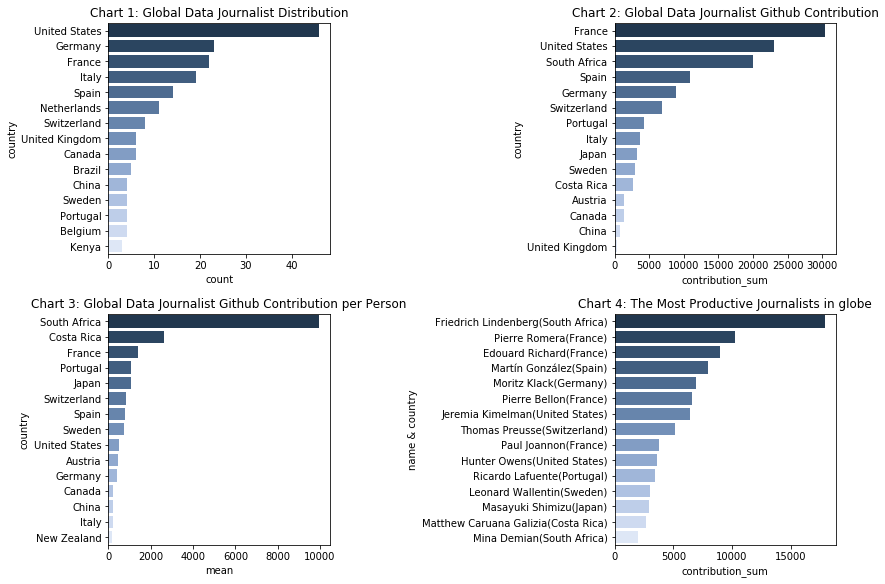

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2,constrained_layout=True,figsize = (12,8))
ax1 = sns.barplot(
    x='count',
    y='country',
    data=df_code_country_data_j.sort_values(
        by=['count'], axis = 0, ascending = False
        ).head(15),
    palette=sns.cubehelix_palette(
        15, start=2.7, rot=0.04, dark=0.2, light=0.9, reverse=True
        ), #palette is like the color combination style
    saturation = 1,
    ax=axes[0,0])
ax1.set_title('Chart 1: Global Data Journalist Distribution', fontsize=12)

ax2 = sns.barplot(
    x='contribution_sum',
    y='country',
    data=df_code_country_data_c.sort_values(
        by=['contribution_sum'], axis = 0, ascending = False
        ).head(15),
    palette=sns.cubehelix_palette(
        15, start=2.7, rot=0.04, dark=0.2, light=0.9, reverse=True
        ), #palette is like the color combination style
    saturation = 1,
    ax=axes[0,1])
ax2.set_title('Chart 2: Global Data Journalist Github Contribution', fontsize=12)

ax3 = sns.barplot(
    x='mean',
    y='country',
    data=df_code_country_data_r.sort_values(
        by=['mean'], axis = 0, ascending = False
        ).head(15),
    palette=sns.cubehelix_palette(
        15, start=2.7, rot=0.04, dark=0.2, light=0.9, reverse=True
        ), #palette is like the color combination style
    saturation = 1,
    ax=axes[1,0])
ax3.set_title('Chart 3: Global Data Journalist Github Contribution per Person', fontsize=12)

ax4 = sns.barplot(
    x='contribution_sum',
    y='name & country',
    data=df_0d.sort_values(
        by=['contribution_sum'], axis = 0, ascending = False
        ).head(15),
    palette=sns.cubehelix_palette(
        15, start=2.7, rot=0.04, dark=0.2, light=0.9, reverse=True
        ), #palette is like the color combination style
    saturation = 1,
    ax=axes[1,1])
ax4.set_title('Chart 4: The Most Productive Journalists in globe', fontsize=12)